# Import Packages and Data

In [248]:
## TODO: T-SNE EMBEDDING OF BINARY DATA

In [149]:
import random
random.seed(5)

In [150]:
#!pip install sklearn

In [151]:
import tensorflow
import keras
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pickle
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam

In [152]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [153]:
x = pd.read_csv("../data/buffer_overflow_graph_embeddings.csv.gz")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID").reset_index(drop=True)

In [154]:
y = labels['bug']
x = x.drop('testcase_ID', axis='columns')

In [155]:
import sklearn

In [156]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 0)

# [Neural tutorial](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)

In [157]:
with open('../data/baseline-model-binary','rb') as f:
    model = pickle.load(f)

In [158]:
nn_evaluate = model.evaluate(x_test,y_test)

10751/10751 [==============================] - 0s 36us/step


In [159]:
nn_score = nn_evaluate[1]

In [160]:
y_pred = model.predict_classes(x)

In [161]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [162]:
y_predict = model.predict(x_test)

In [163]:
import numpy as np
from matplotlib.colors import LogNorm

Change Confusion Matrix Below

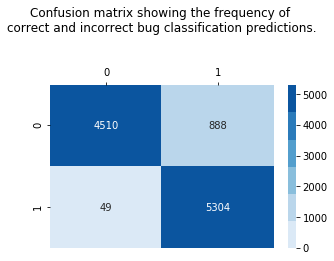

In [164]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [165]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict)).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

# Random Forest

In [267]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [232]:
rf.score(x_test, y_test)

0.6016258629346154

In [233]:
y_pred_rf = pd.DataFrame(rf.predict(x_test))

In [234]:
rf.score(x_test, y_test)

0.6016258629346154

In [169]:
from sklearn.metrics import accuracy_score

In [235]:
rf_accuracy = accuracy_score(y_test, np.rint(y_pred_rf))

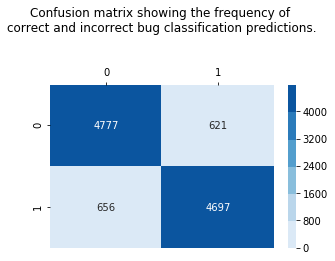

In [236]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_rf)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [237]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_rf)).flatten().tolist()

fpr_rf = fp/(fp+tp)
fnr_rf = fn/(fn+tn)

Sort Visualisation Below!

# KNN

## 1NN

In [240]:
from sklearn.neighbors import KNeighborsClassifier 

oneknn = KNeighborsClassifier(n_neighbors=1, algorithm = 'kd_tree', weights = 'distance')
oneknn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [241]:
y_pred_oneknn = pd.DataFrame(oneknn.predict(x_test))

In [242]:
oneknn_score=oneknn.score(x_test,y_test)

In [243]:
oneknn_score

0.8069946981676123

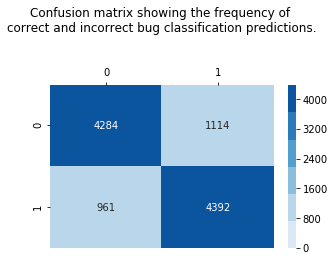

In [177]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_oneknn)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [178]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_oneknn)).flatten().tolist()

fpr_onenn = fp/(fp+tp)
fnr_onenn = fn/(fn+tn)

2NN returns the same as one

## 3NN

In [244]:
from sklearn.neighbors import KNeighborsClassifier 

threeknn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
threeknn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

In [245]:
y_pred_threeknn = pd.DataFrame(threeknn.predict(x_test))

In [246]:
threeknn_score=threeknn.score(x_test,y_test)

In [247]:
threeknn_score

0.7979722816482188

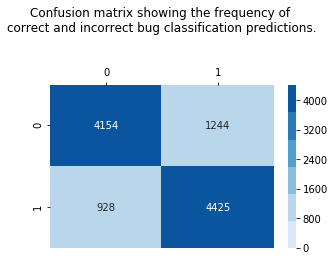

In [183]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_threeknn)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [217]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_threeknn)).flatten().tolist()

fpr_threenn = fp/(fp+tp)
fnr_threenn = fn/(fn+tn)

## Gaussian Naive Bayes

In [185]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred_gnb = gnb.fit(x_train, y_train).predict(x_test)

In [186]:
total_error = (y_test != y_pred_gnb).sum()

print("Number of mislabeled points out of a total %d points : %d"
       % (x_test.shape[0],total_error))
print("Accuracy " + str(1- (total_error/x_test.shape[0])))

Number of mislabeled points out of a total 10751 points : 4348
Accuracy 0.5955725048832667


In [187]:
gnb_score = 1- (total_error/x_test.shape[0])

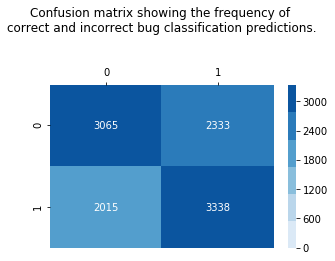

In [188]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_gnb)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [189]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_gnb)).flatten().tolist()

fpr_gnb = fp/(fp+tp)
fnr_gnb = fn/(fn+tn)

## SVM



In [253]:
from sklearn import svm
clf_svm = svm.SVC(kernel = 'poly', gamma='scale', degree = 3)
clf_svm.fit(x_train, y_train)  

y_pred_svm = clf_svm.predict(x_test)

In [254]:
total_error = (y_test != y_pred_svm).sum()

print("Number of mislabeled points out of a total %d points : %d"
       % (x_test.shape[0],total_error))
print("Accuracy " + str(1- (total_error/x_test.shape[0])))

Number of mislabeled points out of a total 10751 points : 1334
Accuracy 0.8759185192075156


In [192]:
svm_score = 1- (total_error/x_test.shape[0])

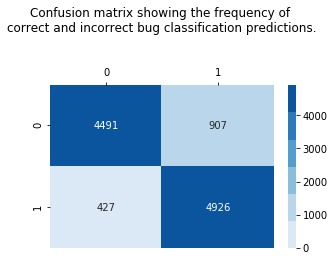

In [193]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_svm)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [194]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_svm)).flatten().tolist()

fpr_svm = fp/(fp+tp)
fnr_svm = fn/(fn+tn)

# Logistic Regression

In [195]:
from sklearn.linear_model import LogisticRegression

In [258]:
logreg = LogisticRegression(penalty = 'l1')
logreg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [259]:
y_pred_lr = logreg.predict(x_test)
print('Accuracy ' + str(logreg.score(x_test, y_test)))

Accuracy 0.8868942423960562


In [260]:
logreg_accuracy = logreg.score(x_test, y_test)

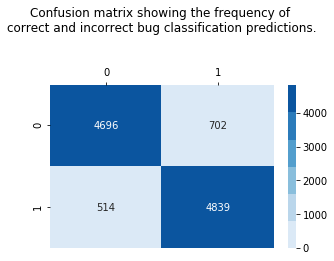

In [261]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_lr)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [262]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_lr)).flatten().tolist()

fpr_logreg = fp/(fp+tp)
fnr_logreg = fn/(fn+tn)

# AdaBoost

In [201]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [202]:
clf_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ab.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [203]:
y_pred_ab = clf_ab.predict(x_test)
# y_pred = y_pred.reshape(-1,1)
# y_pred.shape

In [204]:
total_error = (y_test != y_pred_ab).sum()

print("Number of mislabeled points out of a total %d points : %d"
       % (x_test.shape[0],total_error))
print("Accuracy " + str(1- (total_error/x_test.shape[0])))

Number of mislabeled points out of a total 10751 points : 2223
Accuracy 0.7932285368802903


In [205]:
ab_accuracy = 1- (total_error/x_test.shape[0])

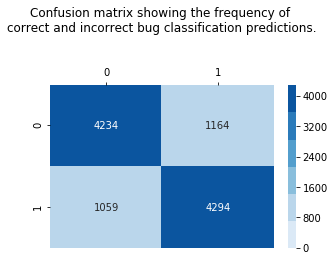

In [206]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_ab)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [207]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_ab)).flatten().tolist()

fpr_ab = fp/(fp+tp)
fnr_ab = fn/(fn+tn)

# XGBoost

In [208]:
#!pip install xgboost

In [209]:
import xgboost as xgb
model_xgb=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_xgb.fit(x_train, y_train)
model_xgb.score(x_test,y_test)

0.6984466561250117

In [210]:
y_pred_xgb = model_xgb.predict(x_test)

In [211]:
total_error = (y_test != y_pred_xgb).sum()

print("Number of mislabeled points out of a total %d points : %d"
       % (x_test.shape[0],total_error))
print("Accuracy " + str(1- (total_error/x_test.shape[0])))

Number of mislabeled points out of a total 10751 points : 3242
Accuracy 0.6984466561250116


In [212]:
xgb_accuracy = 1- (total_error/x_test.shape[0])

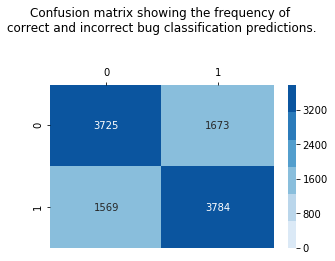

In [213]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_pred_xgb)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [214]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_pred_xgb)).flatten().tolist()

fpr_xgb = fp/(fp+tp)
fnr_xgb = fn/(fn+tn)

# Table of Results

In [263]:
results = {'Model': ['Neural Network', 'Random Forest', '1 Nearest Neighbour', '3 Nearest Neighbours', 'Gaussian Naive Bayes', 'SVM', 'Logistic Regression', 'AdaBoost', 'XGBoost'], 
           'Accuracy' : [nn_score, rf_accuracy, oneknn_score, threeknn_score, gnb_score, svm_score, logreg_accuracy, ab_accuracy, xgb_accuracy],
          'FPR' : [fpr_nn,fpr_rf,fpr_onenn,fpr_threenn,fpr_gnb,fpr_svm,fpr_logreg,fpr_ab,fpr_xgb],
          'FNR' : [fnr_nn,fnr_rf,fnr_onenn,fnr_threenn,fnr_gnb,fnr_svm,fnr_logreg,fnr_ab,fnr_xgb]}
accuracy_table = pd.DataFrame(data = results)

In [264]:
accuracy_table.sort_values(by = ['Accuracy'], ascending=False)

,Model,Accuracy,FPR,FNR
0,Neural Network,0.912845,0.143411,0.010748
6,Logistic Regression,0.886894,0.126692,0.098656
1,Random Forest,0.881220,0.116773,0.120744
5,SVM,0.875919,0.155495,0.086824
2,1 Nearest Neighbour,0.806995,0.202325,0.183222
3,3 Nearest Neighbours,0.797972,0.219439,0.182605
7,AdaBoost,0.793229,0.213265,0.200076
8,XGBoost,0.698447,0.306579,0.296373
4,Gaussian Naive Bayes,0.595573,0.411391,0.396654


# Stacking

In [62]:
!pip install vecstack

  Stored in directory: /root/.cache/pip/wheels/35/6d/ca/bce17942bcf7c267b13c97c9c95e2f0ecf0b42160e6074f448
Successfully built vecstack


In [63]:
from vecstack import stacking

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [270]:
models = [clf_svm, logreg]

In [271]:
S_train, S_test = stacking(models,                   
                           x_train, y_train, x_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [SVC]
    fold  0:  [0.86649312]
    fold  1:  [0.86607143]
    fold  2:  [0.87272051]
    fold  3:  [0.85746185]
    ----
    MEAN:     [0.86568673] + [0.00542957]
    FULL:     [0.86568691]

model  1:     [LogisticRegression]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  0:  [0.89847527]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  1:  [0.88281250]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  2:  [0.87867510]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


    fold  3:  [0.87644213]
    ----
    MEAN:     [0.88410125] + [0.00860782]
    FULL:     [0.88410380]



In [272]:
level_two = rf.fit(S_train, y_train)
y_pred_stack = level_two.predict(S_test)

In [274]:
print('Final prediction score: [%.8f]' % accuracy_score(y_test, np.rint(y_pred_stack)))

Final prediction score: [0.88912659]


In [124]:
# Want to see which models are correlated, perhaps a matlab visualisation task for Junfan